In [1]:
%matplotlib inline

import os
import sys
import datacube
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray as xr
from odc.ui import with_ui_cbk
import pandas as pd

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser
from dea_plotting import rgb
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

In [2]:
dc = datacube.Datacube(app="Triangle_analysis")

In [3]:
# setting up the required latitude and longitude that will match up with the monash paper for validation
lat = (-34,-34.5)
lon = (145,145.5)

# defining a similar period of time for the same purpose
time = ("2015-01-17","2015-02-22")

In [4]:
display_map(x=lon,y=lat)

In [12]:
# loading the specified data for this time period

query = {
    'x': lon,
    'y': lat,
    'time': time,
    'measurements': [
        'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1',
        'nbart_swir_2', 'nbart_panchromatic'
    ],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

triangle = load_ard(dc=dc, products = ['ga_ls8c_ard_3'], **query)


Loading ga_ls8c_ard_3 data
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 2 observations 


In [13]:
print(triangle)

<xarray.Dataset>
Dimensions:             (time: 2, x: 1713, y: 2007)
Coordinates:
  * y                   (y) float64 -3.771e+06 -3.771e+06 ... -3.832e+06
  * x                   (x) float64 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06
  * time                (time) datetime64[ns] 2015-01-24T00:08:23.004012 2015-02-09T00:08:19.307218
Data variables:
    nbart_blue          (time, y, x) float32 nan nan nan ... 719.0 705.0 701.0
    nbart_green         (time, y, x) float32 nan nan nan ... 1067.0 1027.0
    nbart_red           (time, y, x) float32 nan nan nan ... 1367.0 1390.0
    nbart_nir           (time, y, x) float32 nan nan nan ... 2072.0 2036.0
    nbart_swir_1        (time, y, x) float32 nan nan nan ... 2588.0 2536.0
    nbart_swir_2        (time, y, x) float32 nan nan nan ... 1949.0 1997.0
    nbart_panchromatic  (time, y, x) float32 nan nan nan ... 1064.0 1154.0
Attributes:
    crs:      EPSG:3577


In [14]:
# creating the ndvi section fo the triangle database

triangle["ndvi"]=(triangle.nbart_nir-triangle.nbart_red)/(triangle.nbart_nir+triangle.nbart_red)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


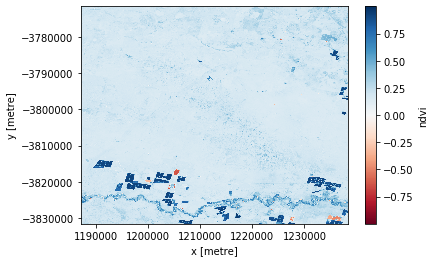

In [15]:
# averaging the ndvi over the time period specified

ave_NDVI = triangle.ndvi.mean(dim="time")

# plotting the average 

ave_NDVI.plot(cmap="RdBu")
plt.show()

In [29]:
# creating the fractional cover index for use in the triangle method

ndvi_min = triangle.ndvi.min()
ndvi_max = triangle.ndvi.max()
print(ndvi_min,ndvi_max)
triangle["frac_cov"] = ((triangle.ndvi-ndvi_min)/(ndvi_max-ndvi_min))**2

<xarray.DataArray 'ndvi' ()>
array(-0.985075, dtype=float32) <xarray.DataArray 'ndvi' ()>
array(0.999545, dtype=float32)


In [30]:
print(triangle)

<xarray.Dataset>
Dimensions:             (time: 2, x: 1713, y: 2007)
Coordinates:
  * y                   (y) float64 -3.771e+06 -3.771e+06 ... -3.832e+06
  * x                   (x) float64 1.187e+06 1.187e+06 ... 1.238e+06 1.238e+06
  * time                (time) datetime64[ns] 2015-01-24T00:08:23.004012 2015-02-09T00:08:19.307218
Data variables:
    nbart_blue          (time, y, x) float32 nan nan nan ... 719.0 705.0 701.0
    nbart_green         (time, y, x) float32 nan nan nan ... 1067.0 1027.0
    nbart_red           (time, y, x) float32 nan nan nan ... 1367.0 1390.0
    nbart_nir           (time, y, x) float32 nan nan nan ... 2072.0 2036.0
    nbart_swir_1        (time, y, x) float32 nan nan nan ... 2588.0 2536.0
    nbart_swir_2        (time, y, x) float32 nan nan nan ... 1949.0 1997.0
    nbart_panchromatic  (time, y, x) float32 nan nan nan ... 1064.0 1154.0
    ndvi                (time, y, x) float32 nan nan ... 0.20500146 0.18855809
    frac_cov            (time, y, x) floa

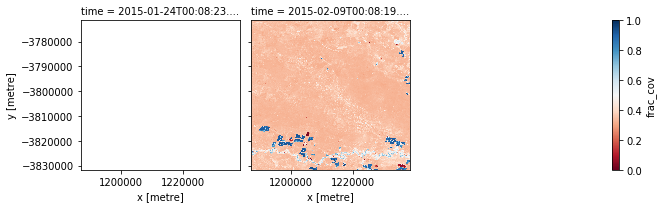

In [32]:
# finding the surface temperature now form the landsat data
# firstly finding the minimum and maximum spectral radiances based off of band 6 measurements (nbart_swir_1)

triangle.frac_cov.plot(cmap="RdBu", col="time", col_wrap=3)
plt.show()